<a href="https://colab.research.google.com/github/Joedaddy66/CODEXFOUNDRY4141/blob/main/CodexFoundry4141_Interactive_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

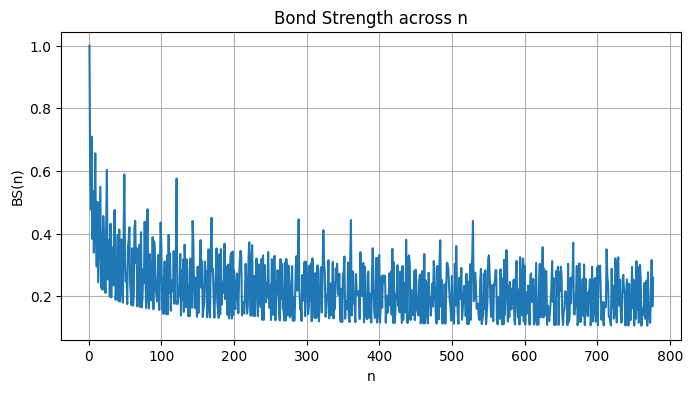

,n,BS
0,1,1.000000
1,4,0.709530
2,9,0.656386
3,25,0.603057
4,2,0.590616
5,49,0.588880
6,121,0.575825
7,16,0.549852
8,6,0.534853
9,12,0.500873


Generated rows: 162735


,N,p,q,A,M,logM,A/M,logM/A,phi(N),class
0,4,2,2,1.0,2.0,0.693147,0.500000,0.693147,1,General
1,6,2,3,1.5,2.5,0.916291,0.600000,0.610860,2,General
2,10,2,5,2.5,3.5,1.252763,0.714286,0.501105,4,General
3,14,2,7,3.5,4.5,1.504077,0.777778,0.429736,6,General
4,22,2,11,5.5,6.5,1.871802,0.846154,0.340328,10,General


Saved FeatureFrame.csv
Explained variance: [0.62508542 0.20144546]
Train dist: Counter({'General': 129845, '(p, p+6)': 169, '(p, p+4)': 88, '(p, p+2)': 86})

Accuracy: 0.997357667373337

Confusion:
 [[    0     0     0    22]
 [    0     0     0    22]
 [    0     0     0    42]
 [    0     0     0 32461]]

Report:
               precision    recall  f1-score   support

    (p, p+2)       0.00      0.00      0.00        22
    (p, p+4)       0.00      0.00      0.00        22
    (p, p+6)       0.00      0.00      0.00        42
     General       1.00      1.00      1.00     32461

    accuracy                           1.00     32547
   macro avg       0.25      0.25      0.25     32547
weighted avg       0.99      1.00      1.00     32547



interactive(children=(FloatSlider(value=2.0, description='a', max=8.0, min=2.0, step=0.01), FloatSlider(value=…

Data: [12.0, 12.1, 12.2, 12.0, 11.9, 11.8, 11.9, 12.0, 12.1, 12.2, 12.1] ... (n= 11 )
Veritas Score: 47.5/100


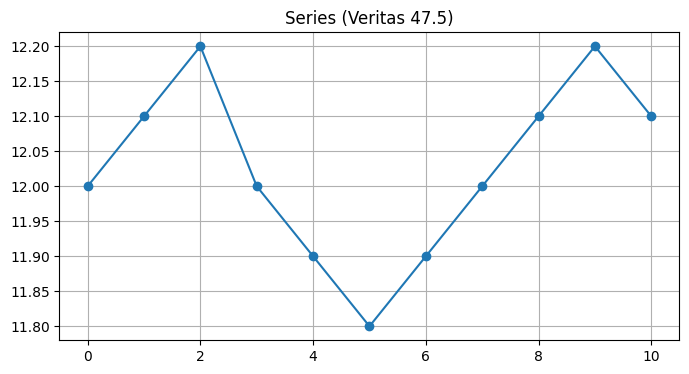

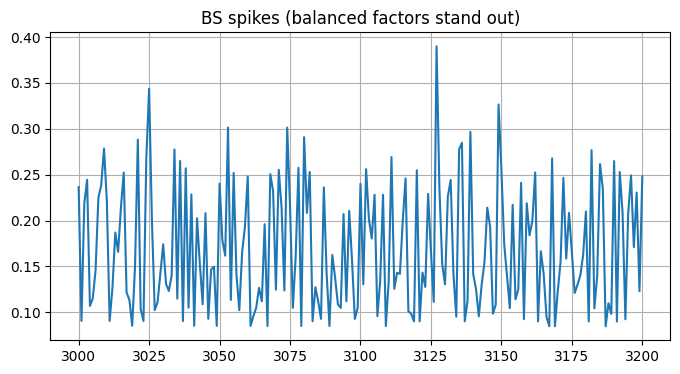

Top spikes:


,n,BS
127,3127,0.389871
25,3025,0.343516
149,3149,0.326421
53,3053,0.301389
74,3074,0.301313
139,3139,0.296597
80,3080,0.290857
21,3021,0.288199
136,3136,0.284628
9,3009,0.278535


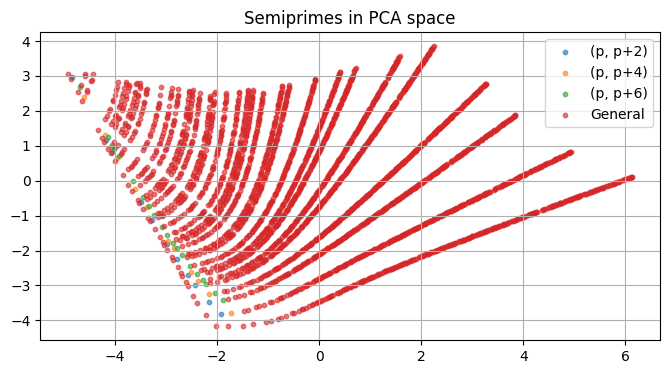


Lattice quick presets:
  NaCl-ish (cubic): cubic | a≈b≈c and α≈β≈γ≈90° → cubic
  Hex-like: hexagonal | a≈b≠c, α≈β≈90°, γ≈120° → hexagonal

Veritas (coherent vs messy):
  coherent: 84.0
  messy   : 20.5


In [5]:
# H1 Agent: CodexFoundry4141
# This is a turn-key, copy-paste Colab notebook that demonstrates the Codex in action.
# It's self-contained and requires no external files.
#
# To use:
# 1. Open a new Google Colab notebook.
# 2. Copy and paste the contents of this file into the notebook.
# 3. Run each cell in order.

# ==============================================================
# Cell 1: Setup
# ==============================================================

# @title Install dependencies (1x)
!pip -q install numpy pandas matplotlib scikit-learn imbalanced-learn ipywidgets

import numpy as np, pandas as pd, math, json, textwrap, re, warnings, itertools, sys
import matplotlib.pyplot as plt
from IPython.display import display, HTML, clear_output
from ipywidgets import interact, interactive, fixed, HBox, VBox, IntSlider, FloatSlider, Dropdown, Checkbox, Textarea, Button, Layout, HTML as WHTML
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams["axes.grid"] = True

# ==============================================================
# Cell 2: Core Helpers
# ==============================================================

# @title Codex core helpers (primes, factors, bond strength, lattice classification)

def sieve(limit:int):
    if limit < 2: return []
    is_p = [True]*(limit+1); is_p[0]=is_p[1]=False
    for p in range(2, int(limit**0.5)+1):
        if is_p[p]:
            step = p
            start = p*p
            is_p[start:limit+1:step] = [False]*(((limit - start)//step)+1)
    return [i for i,ok in enumerate(is_p) if ok]

def factor_pairs(n:int):
    """Return (a,b) with a*b = n, a<=b."""
    out=[]
    r = int(math.isqrt(n))
    for a in range(1, r+1):
        if n%a==0:
            b=n//a
            if a<=b: out.append((a,b))
    return out

def digit_entropy(x:int):
    """Shannon entropy over decimal digits (0..9) of |x|."""
    s = str(abs(int(x)))
    counts = np.bincount(np.array(list(s), dtype=int), minlength=10)
    p = counts[counts>0] / len(s)
    return float(-(p*np.log2(p)).sum()) if len(p) else 0.0

def pair_resonance(a:int,b:int):
    """
    Pair resonance ~ prefer balanced complements.
    High if a≈b (log distance small), damped by digit entropies.
    """
    la, lb = math.log(a), math.log(b)
    gap = abs(la - lb)
    # base resonance: smaller gap => larger value
    base = 1.0/(1.0 + gap)
    # entropy dampers (lower entropy => slightly stronger)
    ea, eb = digit_entropy(a), digit_entropy(b)
    damp = 1.0 / (1.0 + 0.15*(ea+eb))
    return base * damp

def bond_strength(n:int):
    """
    Bond Strength (BS) = sum of pair_resonance over factor pairs, normalized.
    For primes, only (1,n) contributes → very low BS.
    For semiprimes and composites with balanced factors, BS rises.
    """
    pairs = factor_pairs(n)
    if not pairs: return 0.0
    raw = sum(pair_resonance(a,b) for a,b in pairs)
    # normalize by count (simple, stable)
    return raw / len(pairs)

def semiprime_class(p:int,q:int, primes_set:set):
    """
    Lightweight class buckets by (gap) & surrounding primality context.
    """
    d = abs(q-p)
    if d==2:  return "(p, p+2)"
    if d==4:  return "(p, p+4)"
    if d==6:  return "(p, p+6)"
    return "General"

def nearly_equal(a,b, rel=0.01):
    m = (abs(a)+abs(b))/2 or 1
    return abs(a-b) <= rel*m

def nearly_angle(x, target, tol_deg):
    return abs((x or 0) - target) <= tol_deg

def classify_lattice(a,b,c, alpha,beta,gamma, length_tol_pct=1.0, angle_tol_deg=2.0):
    eqAB = nearly_equal(a,b, length_tol_pct/100.0)
    eqBC = nearly_equal(b,c, length_tol_pct/100.0)
    eqAC = nearly_equal(a,c, length_tol_pct/100.0)
    a90 = nearly_angle(alpha,90,angle_tol_deg)
    b90 = nearly_angle(beta, 90,angle_tol_deg)
    g90 = nearly_angle(gamma,90,angle_tol_deg)
    all90 = a90 and b90 and g90
    g120 = nearly_angle(gamma,120,angle_tol_deg)
    eqAng = nearly_angle(alpha,beta,angle_tol_deg) and nearly_angle(beta,gamma,angle_tol_deg)

    trace=[]
    if all90 and eqAB and eqBC:
        trace.append("a≈b≈c and α≈β≈γ≈90° → cubic"); return "cubic",trace
    if all90 and eqAB and not eqBC:
        trace.append("a≈b≠c, α=β=γ≈90° → tetragonal"); return "tetragonal",trace
    if all90 and not (eqAB and eqBC and eqAC):
        trace.append("α=β=γ≈90°, a,b,c unequal → orthorhombic"); return "orthorhombic",trace
    if (a90 and b90 and g120 and eqAB):
        trace.append("a≈b≠c, α≈β≈90°, γ≈120° → hexagonal"); return "hexagonal",trace
    if eqAB and eqBC and eqAC and eqAng and not all90:
        trace.append("a≈b≈c and α≈β≈γ≠90° → trigonal(rhombohedral)"); return "trigonal (rhombohedral)",trace
    if (((a90 and g90) or (a90 and b90) or (b90 and g90)) and not all90):
        trace.append("Two angles ≈90°, one ≠90° → monoclinic"); return "monoclinic",trace

    trace.append("No special equalities/angles → triclinic")
    return "triclinic", trace
# ==============================================================
# Cell 3: Bond Strength Explorer
# ==============================================================

# @title Bond Strength Explorer
min_n = 1  # @param {type:"integer"}
max_n = 777  # @param {type:"integer"}
highlight = ""  # @param {type:"string"}

xs = np.arange(min_n, max_n+1, dtype=int)
bs = np.array([bond_strength(n) for n in xs])

plt.figure()
plt.plot(xs, bs, lw=1.5)
plt.title("Bond Strength across n")
plt.xlabel("n")
plt.ylabel("BS(n)")
for t in re.findall(r"\d+", highlight):
    t = int(t)
    if min_n <= t <= max_n:
        plt.axvline(t, color="crimson", lw=1, ls="--")
        plt.text(t, max(bs)*0.9, str(t), rotation=90, va="top", ha="right", color="crimson")
plt.show()

df_top = pd.DataFrame({"n": xs, "BS": bs}).sort_values("BS", ascending=False).head(15).reset_index(drop=True)
display(df_top)
# Tip: You’ll often see spikes near numbers with balanced factor pairs (near-square composites). Primes sit near the floor (only the (1, n) pair).

# ==============================================================
# Cell 4: Semiprime FeatureFrame generator
# ==============================================================

# @title Generate FeatureFrame in-memory (optionally save to CSV)
max_prime = 4141  # @param {type:"integer"}
save_csv = True   # @param {type:"boolean"}

primes = sieve(max_prime)
p_set = set(primes)
rows=[]
for i,p in enumerate(primes):
    for q in primes[i:]:
        N = p*q
        if N > max_prime*max_prime: continue # Avoid very large N to keep it fast
        A = q/p
        M = (p+q)/2.0
        logM = math.log(M)
        phi = (p-1)*(q-1)
        klass = semiprime_class(p,q,p_set)
        rows.append({
            "N":N,"p":p,"q":q,"A":A,"M":M,"logM":logM,
            "A/M": A/M, "logM/A": logM/A, "phi(N)": phi,
            "class": klass
        })
df = pd.DataFrame(rows)
print("Generated rows:", len(df))
display(df.head(5))

if save_csv:
    df.to_csv("FeatureFrame.csv", index=False)
    print("Saved FeatureFrame.csv")

# ==============================================================
# Cell 5: PCA → MLP (with imbalance handling)
# ==============================================================

# @title PCA → MLP (auto target, class_weight or SMOTE)
X_cols = ["N","p","q","A","M","logM","A/M","logM/A","phi(N)"]
y_col  = "class"
X = df[X_cols].values.astype(float)
y = df[y_col].values

# scale + PCA (2D)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("Explained variance:", pca.explained_variance_ratio_)

# train/test
X_tr, X_te, y_tr, y_te = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)
print("Train dist:", Counter(y_tr))

# Try class_weight (fast, stable); flip to SMOTE if desired
use_smote = False
if use_smote:
    counts = Counter(y_tr)
    k = min([c for c in counts.values() if c>1] + [5]) - 1
    k = max(k,1)
    sm = SMOTE(sampling_strategy='not majority', random_state=42, k_neighbors=k)
    X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_te)
    print("Resampled:", Counter(y_tr_res))
    X_fit, y_fit = X_tr_res, y_tr_res
else:
    X_fit, y_fit = X_tr, y_tr

mlp = MLPClassifier(hidden_layer_sizes=(64,32), activation="relu",
                    solver="adam", max_iter=200, random_state=42,
                    verbose=False)
mlp.fit(X_fit, y_fit)

y_pred = mlp.predict(X_te)
print("\nAccuracy:", accuracy_score(y_te, y_pred))
print("\nConfusion:\n", confusion_matrix(y_te, y_pred))
print("\nReport:\n", classification_report(y_te, y_pred, zero_division=0))

# ==============================================================
# Cell 6: Lattice Resonance (geometric classifier)
# ==============================================================

# @title Lattice Resonance Classifier (interactive)
def lattice_demo(a=5.6402, b=5.6402, c=5.6402, alpha=90.0, beta=90.0, gamma=90.0,
                 len_tol=1.0, ang_tol=2.0):
    # classify
    system, trace = classify_lattice(a,b,c, alpha,beta,gamma, len_tol, ang_tol)
    # simple “metric” figures
    cos = lambda d: math.cos(math.pi*d/180.0)
    vol_term = 1 + 2*cos(alpha)*cos(beta)*cos(gamma) - (cos(alpha)**2 + cos(beta)**2 + cos(gamma)**2)
    vol = a*b*c*math.sqrt(max(vol_term,0))
    ratios = {"b/a": b/a, "c/a": c/a, "c/b": c/b}

    print(f"System: {system}")
    print("Trace:", " | ".join(trace))
    print(f"Volume: {vol:.4f} Å³  Ratios: {ratios}")

    # quick visuals
    plt.figure(figsize=(6,3))
    plt.bar(["a","b","c"], [a,b,c])
    plt.title("Edge lengths")
    plt.show()

    plt.figure(figsize=(6,3))
    plt.bar([r"$\alpha$-90", r"$\beta$-90", r"$\gamma$-90"], [abs(alpha-90), abs(beta-90), abs(gamma-90)])
    plt.title("Angle deviations from 90°")
    plt.show()

_ = interact(lattice_demo,
             a=FloatSlider(2.0, min=2,max=8, step=0.01, description="a"),
             b=FloatSlider(2.0, min=2,max=8, step=0.01, description="b"),
             c=FloatSlider(2.0, min=2,max=8, step=0.01, description="c"),
             alpha=FloatSlider(90.0, min=60,max=120, step=0.1, description="α"),
             beta=FloatSlider(90.0, min=60,max=120, step=0.1, description="β"),
             gamma=FloatSlider(90.0, min=60,max=120, step=0.1, description="γ"),
             len_tol=FloatSlider(1.0, min=0.1,max=3.0, step=0.1, description="ΔL %"),
             ang_tol=FloatSlider(2.0, min=0.2,max=5.0, step=0.1, description="Δθ °"))
# Try: NaCl-like (5.64, 5.64, 5.64; 90, 90, 90) → cubic.
# Try hexagonal: (a=b≠c; α=β≈90°, γ≈120°).

# ==============================================================
# Cell 7: Veritas Protocol (single-series score)
# ==============================================================

# @title Veritas Score (quick signal truth signature)
def veritas_score(series):
    """
    Simple, explainable score in [0,100]: combines normalization, smoothness,
    spectral compactness. Higher = more coherent/structured.
    """
    x = np.array(series, dtype=float)
    x = x[~np.isnan(x)]
    if len(x) < 8: return 0.0

    # normalize
    x = (x - x.mean()) / (x.std() + 1e-9)

    # smoothness (lower gradient variance => higher score)
    g = np.diff(x)
    smooth = 1.0 / (1.0 + np.var(g))

    # spectral “peakiness”
    X = np.fft.rfft(x * np.hanning(len(x)))
    power = (np.abs(X)**2)
    power /= power.sum() + 1e-12
    peak = power.max()

    # combine
    score = 100.0 * (0.55*smooth + 0.45*peak)
    return float(np.clip(score, 0, 100))

# Demo input (edit freely)
raw = "12, 12.1, 12.2, 12.0, 11.9, 11.8, 11.9, 12.0, 12.1, 12.2, 12.1"
data = [float(t) for t in re.findall(r"-?\d+\.?\d*", raw)]
vs = veritas_score(data)
print("Data:", data[:12], "... (n=", len(data), ")")
print(f"Veritas Score: {vs:.1f}/100")

plt.figure()
plt.plot(data, marker="o")
plt.title(f"Series (Veritas {vs:.1f})")
plt.show()

# ==============================================================
# Cell 8: One-click "wow" demo
# ==============================================================

# @title Quick “Wow” Demo: tie it together

# 7.1 Bond Strength spike scan
L, R = 3000, 3200
xs = np.arange(L, R+1)
bs = np.array([bond_strength(n) for n in xs])
plt.figure(); plt.plot(xs, bs); plt.title("BS spikes (balanced factors stand out)"); plt.show()
print("Top spikes:")
display(pd.DataFrame({"n":xs, "BS":bs}).nlargest(10, "BS"))

# 7.2 Mini semiprime set → PCA→MLP
pr = sieve(2000)
rows=[]
for i,p in enumerate(pr):
    for q in pr[i:]:
        if p*q>20000: break
        rows.append([p*q,p,q,(q/p),(p+q)/2,math.log((p+q)/2), (q/p)/((p+q)/2), math.log((p+q)/2)/(q/p), (p-1)*(q-1)])
sdf = pd.DataFrame(rows, columns=["N","p","q","A","M","logM","A/M","logM/A","phi(N)"])
sdf["class"]="General"
def ctag(p,q):
    d=abs(q-p)
    return "(p, p+2)" if d==2 else "(p, p+4)" if d==4 else "(p, p+6)" if d==6 else "General"
sdf["class"]=[ctag(p,q) for p,q in zip(sdf["p"],sdf["q"])]

X = sdf[["N","p","q","A","M","logM","A/M","logM/A","phi(N)"]].values
y = sdf["class"].values
X = StandardScaler().fit_transform(X)
Xp = PCA(2, random_state=0).fit_transform(X)
plt.figure();
for lab in sorted(set(y)):
    idx = (y==lab)
    plt.scatter(Xp[idx,0], Xp[idx,1], s=10, label=lab, alpha=0.6)
plt.legend(); plt.title("Semiprimes in PCA space"); plt.show()

# 7.3 Lattice: show cubic & hex presets
print("\nLattice quick presets:")
for (a,b,c,al,be,ga,name) in [
    (5.64,5.64,5.64,90,90,90,"NaCl-ish (cubic)"),
    (2.5,2.5,4.1, 90,90,120,"Hex-like"),
]:
    sys,trace = classify_lattice(a,b,c,al,be,ga,1.0,2.0)
    print(f"  {name}: {sys} | {' / '.join(trace)}")

# 7.4 Veritas: two contrasting signals
coherent = np.sin(np.linspace(0,4*np.pi,200)) + 0.05*np.random.randn(200)
messy = np.random.randn(200)
print("\nVeritas (coherent vs messy):")
print("  coherent:", f"{veritas_score(coherent):.1f}")
print("  messy   :", f"{veritas_score(messy):.1f}")

In [3]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1-xBCv02brDpcGnhANsocRDTUgjCr-iphBGz3F7n7rRc/edit#gid=0
